---

# CSCI 3202, Spring 2022
# Homework 4
# Due: Friday April 1, 2022 at 6:00 PM

<br> 

### Your name: Ryan Taylor

<br> 

---

Some useful packages and libraries:




In [23]:
from scipy import stats
import unittest
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import floor, isclose
from time import time

## Unit tests

In [24]:
class Tests_Problem1(unittest.TestCase):
    def setUp(self):
        self.p1 = BayesNode('p1', '', [T,F], 0.3)
        self.p2 = BayesNode('p2', '', [T,F], 0.6)
        self.c  = BayesNode('c', ['p1', 'p2'], [T,F], {(T,T):0.1, (T,F):0.2, (F,T):0.3, (F,F):0.4})
    def test_onenode(self):
        self.assertEqual(P(self.p1, T), 0.3)
    def test_twonode(self):
        self.assertEqual(P(self.c, F, {'p1':T, 'p2':F}), 0.8)

---

## Problem 1: (100 Points) Bayesian network to model heart disease

The following Bayesian network is based loosely on a study that examined heart disease risk factors in 167 elderly individuals in South Carolina. Note that this figure uses Y and N to represent Yes and No, whereas in class we used the equivalent T and F to represent True and False Boolean values.

![BayesNet.png](./BayesNet.png)
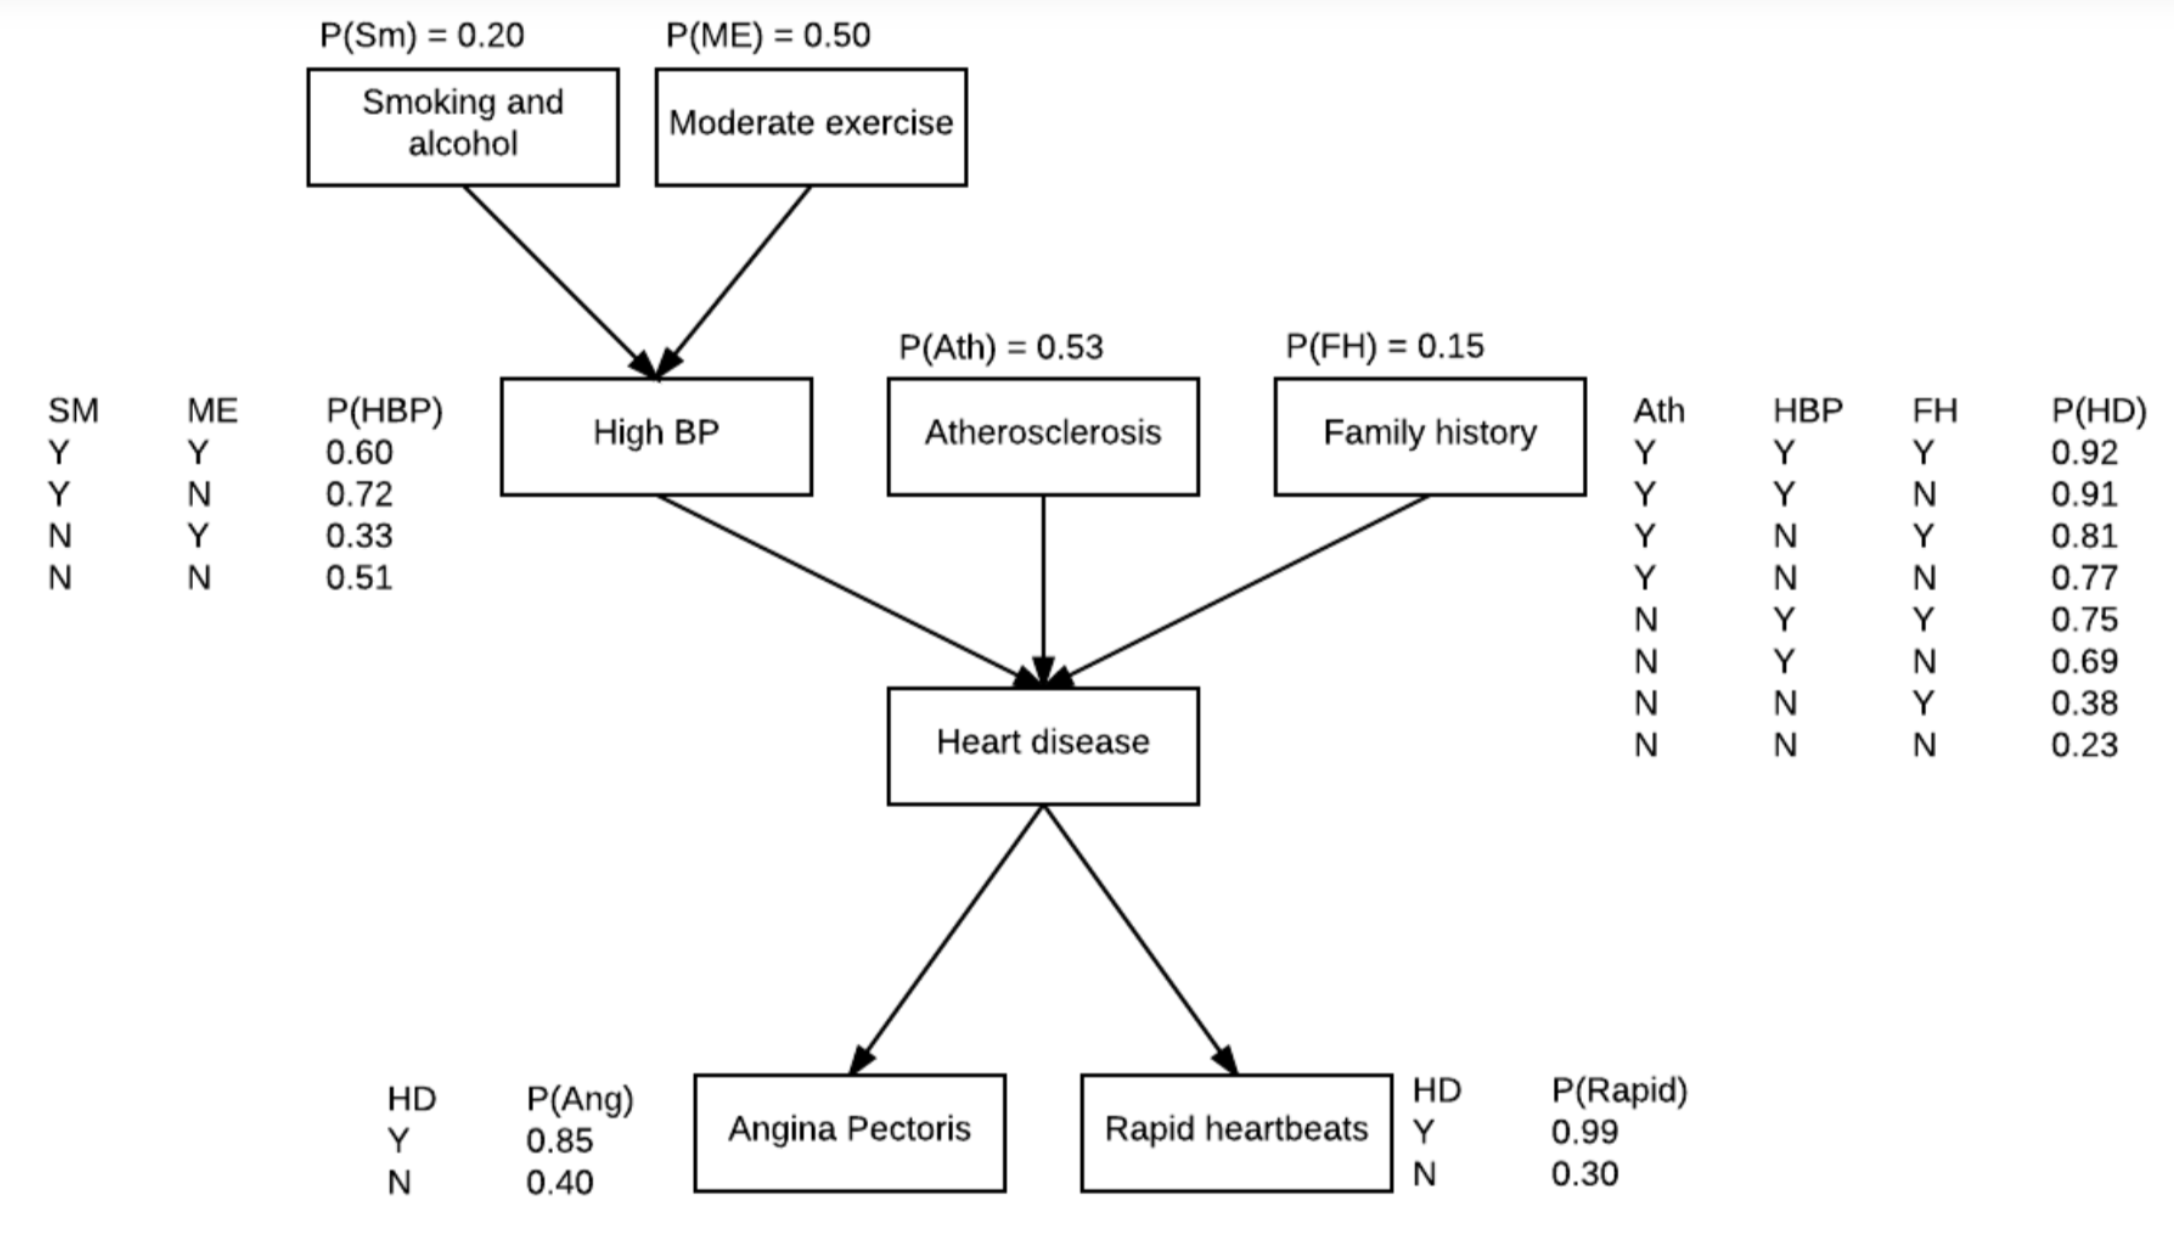

<a id='p1a'></a>

### (1a) 

Create a `BayesNet` object to model this.  Below are the codes for the (conditional) probability `P` function and `BayesNode` class as well, that we used in class on Friday (11 March) to represent the variable nodes and calculate probabilities. You can code this however you want, subject to the following constraints:
1. the nodes are represented using the `BayesNode` class and can work with the `P` function for probabilities,
1. your `BayesNet` structure keeps track of which nodes are in the Bayes net, as well as
1. which nodes are the parents/children of which other nodes.

Some *suggested* skeleton codes for a class structure are given. The suggestions for methods to implement are in view of the fact that we will need to calculate some probabilities, which is going to require us to `find_node`s and `find_values` that nodes can take on.

In [36]:
## For the sake of brevity...
T, F = True, False

## From class:
def P(var, value, evidence={}):
    '''The probability distribution for P(var | evidence), 
    when all parent variables are known (in evidence)'''
    if len(var.parents)==1:
        # only one parent
        row = evidence[var.parents[0]]
    else:
        # multiple parents
        row = tuple(evidence[parent] for parent in var.parents)
    return var.cpt[row] if value else 1-var.cpt[row]

## Also from class:
class BayesNode:
    
    def __init__(self, name, parents, values, cpt):
        if isinstance(parents, str):
            parents = parents.split()
            
        if len(parents)==0:
            # if no parents, empty dict key for cpt
            cpt = {(): cpt}
        elif isinstance(cpt, dict):
            # if there is only one parent, only one tuple argument
            if cpt and isinstance(list(cpt.keys())[0], bool):
                cpt = {(v): p for v, p in cpt.items()}

        self.variable = name
        self.parents = parents
        self.cpt = cpt
        self.values = values
        self.children = []
        
    def __repr__(self):
        return repr((self.variable, ' '.join(self.parents)))    

    
##===============================================##
## Suggested skeleton codes for a BayesNet class ##
##===============================================##

class BayesNet:
    '''Bayesian network containing only boolean-variable nodes.'''

    def __init__(self, nodes):
        '''Initialize the Bayes net by adding each of the nodes,
        which should be a list BayesNode class objects ordered
        from parents to children (`top` to `bottom`, from causes
        to effects)'''
        
        self.nodes = nodes
        self.variables = []

                
    def add(self, node):
        '''Add a new BayesNode to the BayesNet. The parents should all
        already be in the net, and the variable itself should not be'''
        assert node.variable not in self.variables
        assert all((parent in self.variables) for parent in node.parents)
        
        self.nodes.append(node)
        self.variables.append(node.variable)
        for parent in node.parents:
            self.find_node(parent).children.append(node)
        
            
    def find_node(self, var):
        '''Find and return the BayesNode in the net with name `var`'''
        
        for n in self.nodes:
            if n.variable == var:
                return n
        raise Exception("No such variable: {}".format(var))
        
        
    def find_values(self, var):
        '''Return the set of possible values for variable `var`'''
        
        varnode = self.find_node(var)
        return varnode.values
        
    
    def __repr__(self):
        return 'BayesNet({})'.format(self.nodes)


# create net
net = BayesNet([])
net.add(BayesNode('Smoking and alcohol', '', [T, F], 0.2))
net.add(BayesNode('Moderate exercise', '', [T, F], 0.5))
net.add(BayesNode('High BP', ['Smoking and alcohol', 'Moderate exercise'], [T, F], {(T, T): 0.6, (T, F): 0.72, (F, T): 0.33, (F, F): 0.51}))
net.add(BayesNode('Atherosclerosis', '', [T, F], 0.53))
net.add(BayesNode('Family history', '', [T, F], 0.15))
net.add(BayesNode('Heart disease', ['High BP', 'Atherosclerosis', 'Family history'], [T, F], {(T, T, T): 0.92, (T, T, F): 0.91, (T, F, T): 0.81, (T, F, F): 0.77, (F, T, T): 0.75, (F, T, F): 0.69, (F , F, T): 0.38, (F, F, F): 0.23}))
net.add(BayesNode('Angina pectoris', ['Heart disease'], [T, F], {T: 0.85, F: 0.4}))
net.add(BayesNode('Rapid heartbeats', ['Heart disease'], [T, F], {T: 0.99, F: 0.3}))

#### Unit tests

In [37]:
tests_to_run = unittest.TestSuite()
tests_to_run.addTest(Tests_Problem1("test_onenode"))
tests_to_run.addTest(Tests_Problem1("test_twonode"))
unittest.TextTestRunner().run(tests_to_run)

..
----------------------------------------------------------------------
Ran 2 tests in 0.008s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>


### (1b)

Craft a function `get_prob(X, e, bn)` to return the **normalized** probability distribution of variable `X` in Bayes net `bn`, given the evidence `e`.  That is, return $P(X \mid e)$. The arguments are:
* `X` is some representation of the variable you are querying the probability distribution of. Either a string (the variable name from the `BayesNode` or a `BayesNode` object itself are good options.
* `e` is some representation of the evidence your probability is conditioned on. When given an empty argument (or `None`) for `e`, `get_prob` should return the marginal distribution $P(X)$.
* `bn` is your `BayesNet` object.

You may do this using the `enumeration` algorithm from class (pseudocode is in the book, code example is in the notebook from March 11), or by brute force (i.e., use a few `for` loops). Either way, you should be using your `BayesNet` object to keep track of all the nodes and relationships between nodes so your `get_prob` function knows these things.

In [38]:
class PDF_discrete:


    def __init__(self, varname='?', freqs=None):

        self.prob = {}
        self.varname = varname
        self.values = []
        if freqs:
            for (v, p) in freqs.items():
                self[v] = p
        self.normalize()

    def __getitem__(self, value):

        try:
            return self.prob[value]
        except KeyError:
            return 0

    def __setitem__(self, value, p):

        if value not in self.values:
            self.values.append(value)
        self.prob[value] = p

    def normalize(self):

        total = sum(self.prob.values())
        if not isclose(total, 1.0):
            for value in self.prob:
                self.prob[value] /= total
        return self
    
def extend(s, var, val):

    s2 = s.copy()
    s2[var] = val
    return s2





def get_prob(X, e, bn):

    Q = PDF_discrete(X)
    for xi in bn.find_values(X):
        Q[xi] = enumerate_all(bn.variables, extend(e, X, xi), bn)
    return Q.normalize()


def enumerate_all(variables, e, bn):

    if not variables:
        return 1.0
    Y, rest = variables[0], variables[1:]
    Ynode = bn.find_node(Y)
    if Y in e:
        
        return P(Ynode, e[Y], e) * enumerate_all(rest, e, bn)
    else:

        return sum(P(Ynode, y, e) * enumerate_all(rest, extend(e, Y, y), bn)
                   for y in bn.find_values(Y))

Use your `get_prob` function to calculate the following probabilities. Print them to the screen and compare to the original Bayes net figure given to make sure the output passes these "unit tests".

1. The marginal probability of `Family History` is $P(FH=T)=0.15$
2. The probability of *not* experiencing `Angina Pectoris`, given `Heart Disease` is observed, is $P(Ang=F \mid HD=T)=1-0.85=0.15$
3. The probability of `High Blood Pressure`, given a person does `Smoke and/or use Alcohol` but does not get `Moderate Exercise`, is $P(HBP=T \mid Sm=T, ME=F)=0.72$

In [39]:
print("Family history:", get_prob(X='Family history', e={}, bn=net).prob[True])
print("Angina given heart disease:", get_prob(X='Angina pectoris', e={'Heart disease' : T}, bn=net).prob[False])
print("HBP given Smoke/Alcohol, no exercise:", get_prob(X='High BP', e={'Smoking and alcohol' : T, 'Moderate exercise' : F}, bn=net).prob[True])

Family history: 0.15
Angina given heart disease: 0.1500000000000001
HBP given Smoke/Alcohol, no exercise: 0.7199999999999999



### (1c)

Calculate the probability of observing someone with `High Blood Pressure`, $P(HBP=T)$, *by hand*, showing all work in Markdown/LateX below.

Given the only parents to High BP are *Smoking and alcohol* and *Moderate exercise*, all we need is the provided CPT for High BP. We'll use $Y=0.2$ and $N=0.8$ for *Smoking and alcohol*, and $Y=N=0.5$ for *Moderate exercise* based on the given probabilities for both.

$P(HBT=T) = (0.2 * 0.5 * 0.6) + (0.2 * 0.5 * 0.72) + (0.8 * 0.5 * 0.33) + (0.8 * 0.5 * 0.51)$  
$P(HBT=T) = 0.468$

**Verify** your calculation using your `get_prob` function.

In [40]:
print("High Blood Pressure:", get_prob(X='High BP', e={}, bn=net).prob[True])

High Blood Pressure: 0.4680000000000001



### (1d)

Now calculate the following probabilities using your `get_prob` function.

[i] The probability of an arbitrary individual having `Heart Disease`, $P(HD=T)$

In [41]:
print(get_prob(X='Heart disease', e={'Heart disease' : T}, bn=net).prob[True])

0.65700256


[ii] The probability that an individual does *not* have `Heart Disease`, given that `Rapid Heartbeat` was observed, $P(HD=F \mid Rapid=T)$

In [42]:
print(get_prob(X='Heart disease', e={'Rapid heartbeat' : T}, bn=net).prob[False])

0.34299744


[iii] The probability of an individual having `High Blood Pressure` if they have `Heart Disease` and a `Family History`, $P(HBP=T \mid HD=T, FH=T)$

In [43]:
print(get_prob(X='High BP', e={'Heart disease': T, 'Family History': T}, bn=net).prob[True])

0.603920660522236


[iv] The probability that an individual is a `Smoker/Alcohol User` if they have `Heart Disease`, $P(Sm=T \mid HD=T)$

In [44]:
print(get_prob(X='Smoking and alcohol', e={'Heart disease': T}, bn=net).prob[True])

0.22096327904719273


[v] How would you expect the probability in [iv] to change if you also know the individual has `High Blood Pressure`?  Verify your hypothesis by calculating the relevant probability.

I would expect the probability to **increase**. If we only know the individual has heart disease, there is a possiblity they only have Anthersclerosis or a Family history, not necessarily High BP which traces back to Smoking and alcohol use. Knowing they have High BP certainly gets us one level closer to smoking and alcohol, the only alternative being not exercising.

In [45]:
print(get_prob(X='Smoking and alcohol', e={'Heart disease': T, 'High BP': T}, bn=net).prob[True])

0.282051282051282


[vi] How would you expect the probability in [v] to change if you also know that the individual does *not* get `Moderate Exercise` (in addition to having `Heart Disease` and `High Blood Pressure`)?  Explain your answer using concepts from class.  Verify your answer by calculating the relevant probability.

I would expect the probability to be slightly different, however not by much. Knowing a lack of moderate exercise does not help much, as their heart High BP could have been caused by either attribute. The probabilites know that moderate exercise is false also do not tell us much to help estimate the probability of smoking and alcohol.

In [35]:
print(get_prob(X='Smoking and alcohol', e={'Heart disease': T, 'High BP': T, 'Moderate exercise': F}, bn=net).prob[True])

0.26086956521739124


---


<img src="https://inhabitat.com/wp-content/blogs.dir/1/files/2014/02/norman-bike-riding-dog.png" style="width: 350px;"/>

## Problem 2:  (Extra Credit) Bayesian network to model decision-making

Let's consider using a Bayesian network to model our decision about whether or not to ride our bike to work today.  This decision depends heavily on the weather, so let's focus on that.

In class, we focused on Boolean variables.  For example, we might base our biking decision on whether or not it is raining.  But in reality, it probably matters *how hard* it is raining.  So suppose we break the variable `Rain` up into three discrete bins: `none`, `light` and `heavy`.

The temperature also factors into our decision.  There is definitely a sweet spot, where temperatures are neither too warm nor too cold, so it is very likely we would enjoy riding our bike.  So we can model the variable `Temperature` also using three discrete bins: `cold`, `moderate` and `warm`.

So a Bayesian network to model our decision for whether or not to bike to work could be as follows, where the first letter of each discrete bin is used to denote that variable value (i.e., `R=h` stands for heavy rain conditions).

<img src="http://www.cs.colorado.edu/~tonyewong/home/resources/bayesnet_biking2.png" style="width: 650px;"/>


### (2a)

Modify the `P` probability function to be able to handle these ternary parent nodes.

In [ ]:
# Your code here.

Set up `BayesNode` objects for each of `Rain`, `Temp` and `Bike`, and create a `BayesNet` object to model the Bayesian network for this decision.  Again, you can use whatever structure you wish for your `BayesNet`, but please use the `BayesNode` class.  You may need to make minor modifications to the `BayesNode` class (e.g., changing/adding attributes), although none are strictly necessary.

In [ ]:
# Your code here.

**Verify** that your modified probability function `P` is working by checking the following "unit tests". Print the output to screen and compare to what you expect from the figure above.

1. The marginal probability of no rain is $P(Rain=n)=0.8$
1. The marginal probability of light rain is $P(Rain=l)=0.15$
1. The marginal probability of heavy rain is $P(Rain=h)=0.05$
1. The probability of biking given that it is raining heavily and the temperature is cold, is $P(Bike=T \mid Rain=h, Temp=c)=0.2$

In [ ]:
# Your code here.


### (2b)

Make any necessary modifications to your `get_prob` function from Problem 1, so that you can use it to calculate marginal probabilities and conditional probabilities for this problem. It is possible that your function does not require any modifications.

In [ ]:
# Your code here.

Use `get_prob` to calculate $P(Bike)$, the probability distribution for whether or not you will ride your bike on any given day.

In [ ]:
# Your code here.

Use `get_prob` to calculate the probability that you will ride your bike, given that it is lightly raining.

In [ ]:
# Your code here.


### (2c)

We are trapped indoors because some jerk gave us a ton of Intro to Artificial Intelligence homework to do.  Suppose we look out the window and see people biking. They sure do look like they're having fun! *Given* this information, we can actually make inferences regarding the temperature outside!  What is the probability distribution for temperature, given that we observe people biking?

First, compute this using your `get_prob` function.

In [ ]:
# Your code here.


### (2d)

Confirm your answer to **2c** by hand, showing *all* relevant work below in a LateX/Markdown cell.


### (2e)

Finally, confirm your confirmation of the probability distribution for `Temp` by using approximate Bayesian computation and 10,000 samples.  That is, use the **prior sampling** and **"rejection sampling"** techniques from class to estimate the probabilities associated with each possible value for `Temp`, given that there are people biking outside.

In [ ]:
# Your code here.

As a "Unit Test", check what the probability of riding your bike is, given no other information.  Make sure this approximately matches your answer to **2b**.

In [ ]:
# Your code here.